### Functions and import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

#### Plot 1

In [2]:
def plot_avg(df):
    df['Date']= pd.to_datetime(df['Date'])
    df.index = df['Date']
    df["MA1"] = df['Close'].rolling(window=50).mean()
    df["MA2"] = df['Close'].rolling(window=200).mean()
    plt.figure(figsize=(10,7))
    plt.plot(df['Date'],df['MA1'], 'g--', label="Moving Avg 1")
    plt.plot(df['Date'],df['MA2'], 'r--', label="Moving Avg 2")
    plt.plot(df['Date'],df['Close'],label="Close")
    plt.legend()
    plt.savefig('imgs/'+df.name+'avg.png')
    plt.show()

#### plot 2

In [3]:
def plot_bollinger(df): 
    df['middle_band'] = df['Close'].rolling(window=20).mean()
    df['upper_band'] = df['Close'].rolling(window=20).mean() + df['Close'].rolling(window=20).std()*2
    df['lower_band'] = df['Close'].rolling(window=20).mean() - df['Close'].rolling(window=20).std()*2
    plt.figure(figsize=(10,7))
    plt.plot(df['Date'],df['upper_band'], 'g--', label="upper")
    plt.plot(df['Date'],df['middle_band'], 'r--', label="middle")
    plt.plot(df['Date'],df['lower_band'], 'y--', label="lower")
    plt.plot(df['Date'],df['Close'], label="close")
    plt.legend()
    plt.savefig('imgs/'+df.name+'bb.png')
    plt.show()

#### LSTM model

In [4]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import numpy as np

def lstm_model(df,l = 60,n_units = 50):
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']
    
    data = df.sort_index(ascending=True, axis=0)
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
    
    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data['Close'][i]
        
    new_data.index = new_data.Date
    new_data.drop('Date', axis=1, inplace=True)
    
    dataset = new_data.values
    
    n = int(new_data.size*0.8)
    
    train = dataset[0:n,:]
    valid = dataset[n:,:]

    #converting dataset into x_train and y_train
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    
    #length of sequence (l) 
    
    x_train, y_train = [], []
    for i in range(l,len(train)):
        x_train.append(scaled_data[i-l:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
    model = Sequential()
    model.add(LSTM(units=n_units, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=n_units))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=1)
    
    inputs = new_data[len(new_data) - len(valid) - l:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    
    X_test = []
    for i in range(l,inputs.shape[0]):
        X_test.append(inputs[i-l:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    
    print('rms = '+str(np.sqrt(np.mean(np.power((valid-closing_price),2)))))
    
    train = new_data[:n]
    valid = new_data[n:]
    valid['Predictions'] = closing_price
    plt.figure(figsize=(10,7))
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']]) 
    plt.savefig('imgs/'+df.name+'mdl.png')
    plt.show()

### Cognizant

In [5]:
cognizant = pd.read_csv('Datasets/Cognizant.csv',delimiter=',')
cognizant.name = 'cognizant'
cognizant.head()

,Date,Open,High,Low,Close,Volume
0,2019-01-02,62.500000,63.810001,62.500000,63.090000,3045600
1,2019-01-03,62.360001,62.970001,61.009998,61.099998,3895700
2,2019-01-04,62.279999,63.799999,61.950001,63.700001,4885600
3,2019-01-07,63.349998,63.970001,62.799999,63.599998,3940400
4,2019-01-08,64.269997,64.430000,63.439999,64.320000,3427500


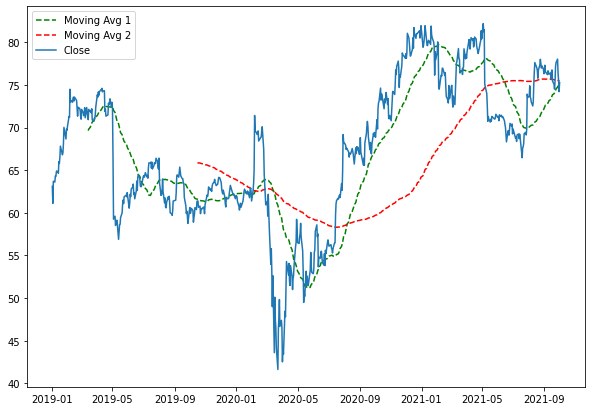

In [6]:
plot_avg(cognizant)

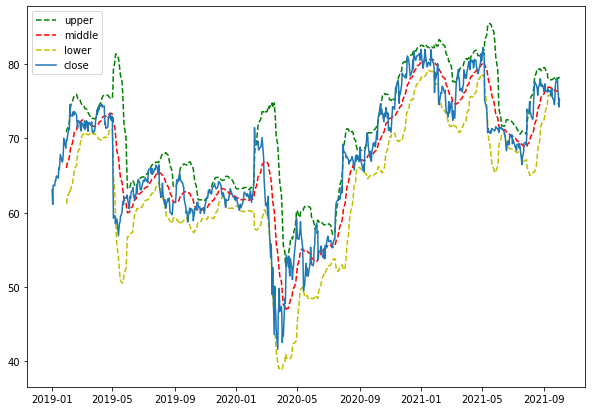

In [7]:
plot_bollinger(cognizant)

495/495 [==============================] - 4s 6ms/step - loss: 0.0102
rms = 1.660145978934017


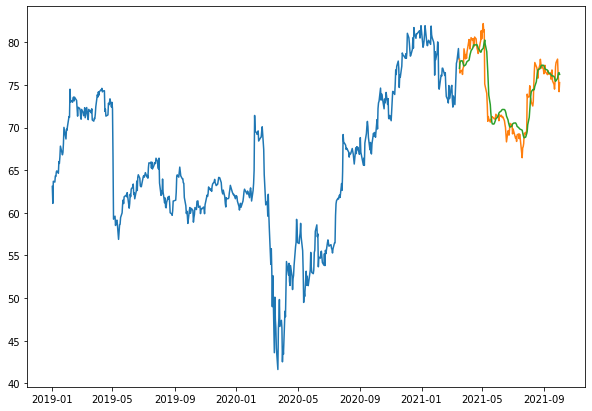

In [9]:
lstm_model(cognizant,l = 60,n_units = 50)

### HCL

In [23]:
hcl = pd.read_csv('Datasets/HCL.csv',delimiter=',')
hcl.head()

,Date,Open,High,Low,Close,Volume
0,2020-10-05,828.799988,839.200012,815.099976,824.200012,11889998.0
1,2020-10-06,830.000000,834.500000,822.700012,829.150024,7848500.0
2,2020-10-07,830.000000,830.599976,823.000000,828.049988,6980002.0
3,2020-10-08,857.500000,879.000000,844.500000,849.549988,25860257.0
4,2020-10-09,852.900024,862.500000,849.299988,855.750000,7286954.0


In [24]:
hcl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    249 non-null    object 
 1   Open    248 non-null    float64
 2   High    248 non-null    float64
 3   Low     248 non-null    float64
 4   Close   248 non-null    float64
 5   Volume  248 non-null    float64
dtypes: float64(5), object(1)
memory usage: 11.8+ KB


In [25]:
hcl = hcl.dropna(axis = 0, how ='any')
hcl.name = 'hcl'

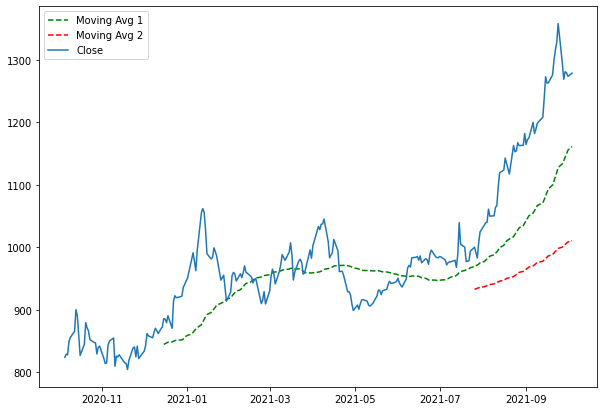

In [26]:
plot_avg(hcl)

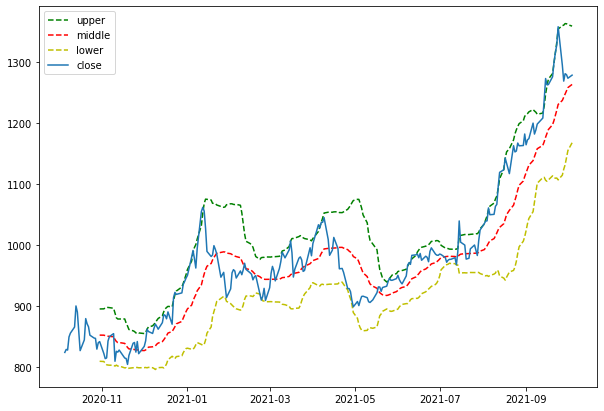

In [27]:
plot_bollinger(hcl)

168/168 [==============================] - 2s 4ms/step - loss: 0.0065
rms = 99.39818889281973


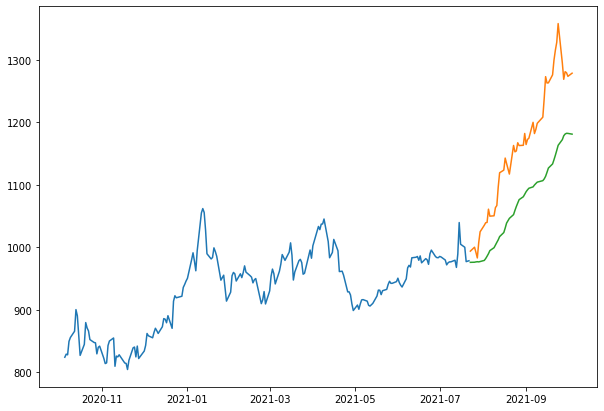

In [35]:
lstm_model(hcl,l = 30,n_units = 50)

### HDFC

In [36]:
hdfc = pd.read_csv('Datasets/HDFC.csv',delimiter=',')
hdfc.head()

,Date,Open,High,Low,Close,Volume
0,2019-01-01,1063.824951,1075.500000,1052.800049,1074.050049,3186720.0
1,2019-01-02,1071.400024,1073.750000,1059.849976,1064.250000,4067116.0
2,2019-01-03,1062.099976,1064.125000,1051.500000,1055.900024,6385832.0
3,2019-01-04,1057.625000,1064.250000,1055.175049,1058.724976,3643560.0
4,2019-01-07,1063.849976,1067.675049,1059.000000,1060.324951,2693506.0


In [37]:
hdfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    680 non-null    object 
 1   Open    678 non-null    float64
 2   High    678 non-null    float64
 3   Low     678 non-null    float64
 4   Close   678 non-null    float64
 5   Volume  678 non-null    float64
dtypes: float64(5), object(1)
memory usage: 32.0+ KB


In [39]:
hdfc = hdfc.dropna(axis = 0, how ='any')
hdfc.name = 'hdfc'

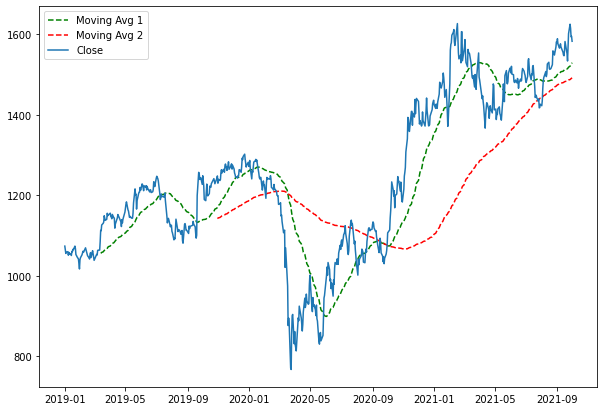

In [40]:
plot_avg(hdfc)

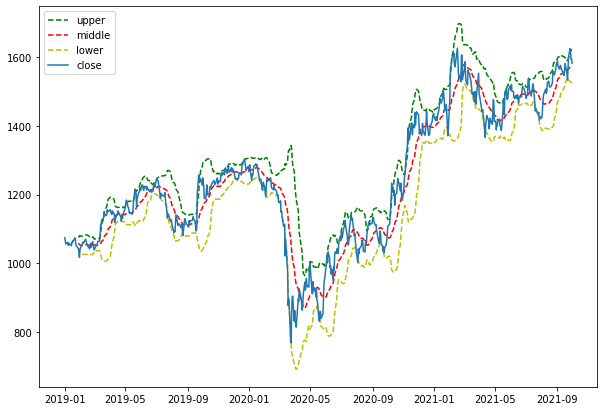

In [41]:
plot_bollinger(hdfc)

482/482 [==============================] - 4s 5ms/step - loss: 0.0065
rms = 42.87981809202461


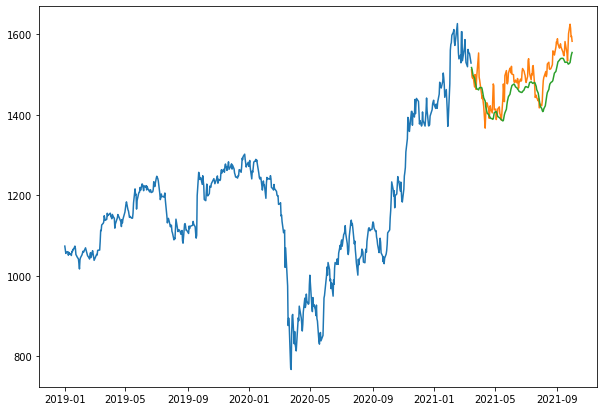

In [43]:
lstm_model(hdfc,l = 60,n_units = 50)

### ICICI

In [44]:
icici = pd.read_csv('Datasets/ICICI.csv',delimiter=',')
icici.head()

,Date,Open,High,Low,Close,Volume
0,2019-01-01,361.500000,364.799988,356.399994,363.750000,7759872.0
1,2019-01-02,361.500000,367.899994,360.299988,364.600006,18243156.0
2,2019-01-03,365.000000,367.299988,362.049988,363.250000,12884409.0
3,2019-01-04,361.850006,368.799988,358.049988,365.200012,22896026.0
4,2019-01-07,367.500000,371.000000,366.549988,367.700012,12719847.0


In [45]:
icici.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    680 non-null    object 
 1   Open    678 non-null    float64
 2   High    678 non-null    float64
 3   Low     678 non-null    float64
 4   Close   678 non-null    float64
 5   Volume  678 non-null    float64
dtypes: float64(5), object(1)
memory usage: 32.0+ KB


In [46]:
icici = icici.dropna(axis = 0, how ='any')
icici.name = 'icici'

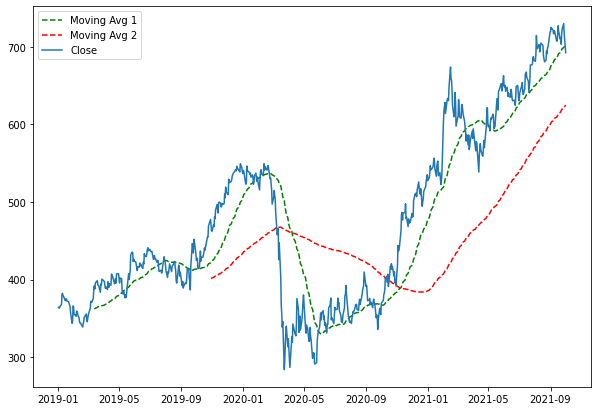

In [47]:
plot_avg(icici)

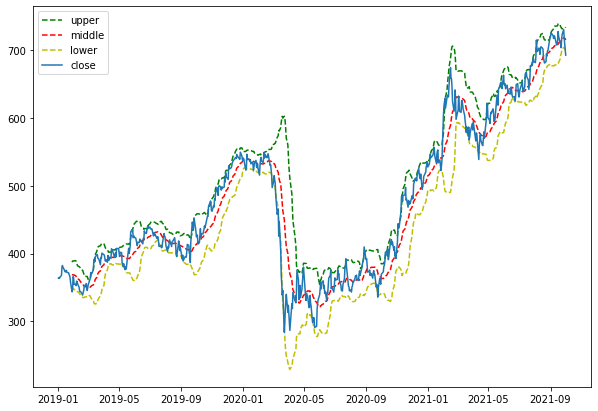

In [48]:
plot_bollinger(icici)

482/482 [==============================] - 4s 6ms/step - loss: 0.0058
rms = 16.239907654874678


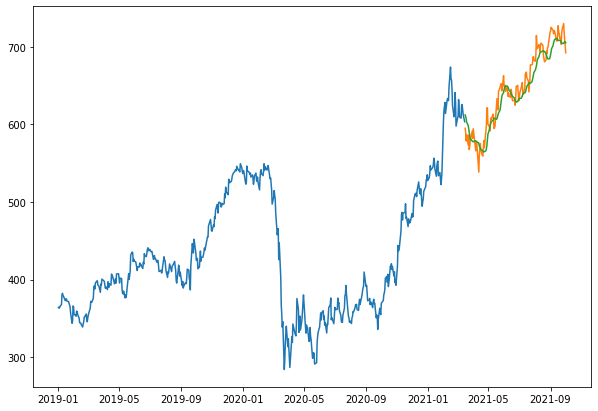

In [49]:
lstm_model(icici,l = 60,n_units = 50)

### Infosys

In [51]:
infosys = pd.read_csv('Datasets/Infosys.csv',delimiter=',')
infosys.head()

,Date,Open,High,Low,Close,Volume
0,2020-10-05,1018.049988,1054.900024,1018.049988,1048.699951,14212509.0
1,2020-10-06,1055.000000,1060.000000,1031.349976,1055.750000,9090819.0
2,2020-10-07,1044.900024,1072.000000,1035.500000,1066.550049,9284008.0
3,2020-10-08,1090.000000,1124.000000,1088.400024,1093.699951,21482613.0
4,2020-10-09,1095.099976,1113.300049,1088.449951,1106.800049,10567867.0


In [52]:
infosys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    249 non-null    object 
 1   Open    248 non-null    float64
 2   High    248 non-null    float64
 3   Low     248 non-null    float64
 4   Close   248 non-null    float64
 5   Volume  248 non-null    float64
dtypes: float64(5), object(1)
memory usage: 11.8+ KB


In [53]:
infosys = infosys.dropna(axis = 0, how ='any')
infosys.name = 'infosys'

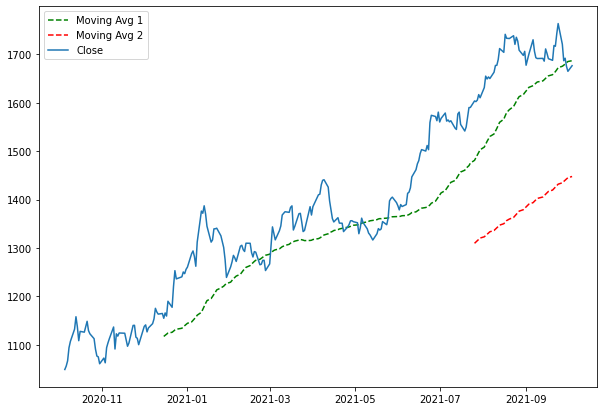

In [58]:
plot_avg(infosys)

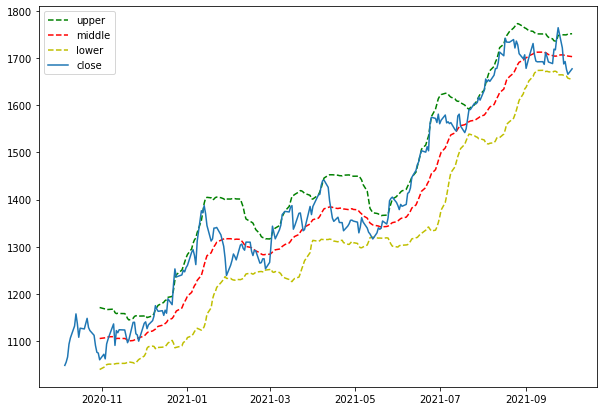

In [59]:
plot_bollinger(infosys)

168/168 [==============================] - 2s 4ms/step - loss: 0.0090
rms = 34.143380118591935


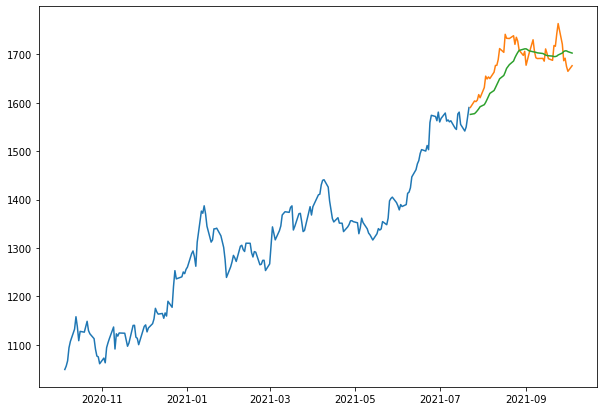

In [62]:
lstm_model(infosys,l = 30,n_units = 50)

### SBI

In [63]:
sbi = pd.read_csv('Datasets/SBI.csv',delimiter=',')
sbi.head()

,Date,Open,High,Low,Close,Volume
0,2019-01-01,297.500000,300.700012,293.850006,299.600006,11837127.0
1,2019-01-02,299.100006,302.500000,293.100006,293.899994,25559853.0
2,2019-01-03,295.000000,295.549988,290.100006,291.100006,17548347.0
3,2019-01-04,292.100006,299.000000,291.500000,297.649994,19514041.0
4,2019-01-07,301.049988,301.500000,295.200012,296.299988,14579399.0


In [64]:
sbi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    680 non-null    object 
 1   Open    678 non-null    float64
 2   High    678 non-null    float64
 3   Low     678 non-null    float64
 4   Close   678 non-null    float64
 5   Volume  678 non-null    float64
dtypes: float64(5), object(1)
memory usage: 32.0+ KB


In [65]:
sbi = sbi.dropna(axis = 0, how ='any')
sbi.name = 'sbi'

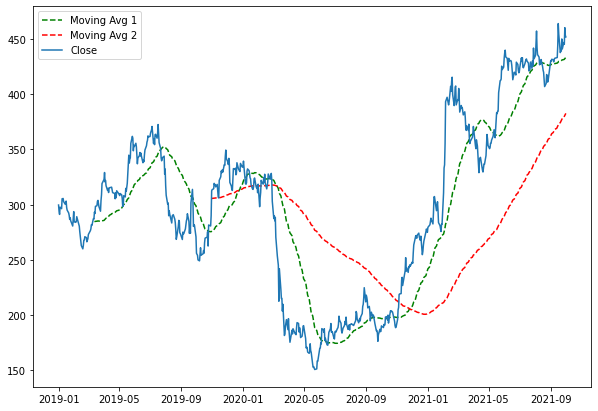

In [66]:
plot_avg(sbi)

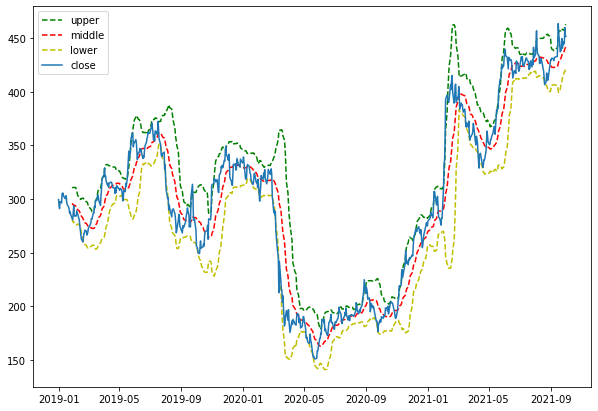

In [67]:
plot_bollinger(sbi)

482/482 [==============================] - 4s 6ms/step - loss: 0.0073
rms = 16.55960150265356


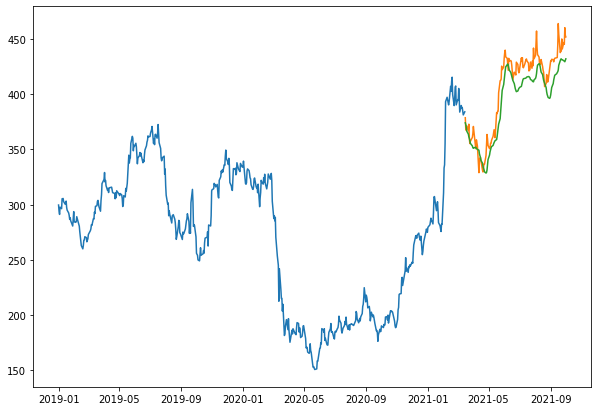

In [69]:
lstm_model(sbi,l = 60,n_units = 50)

### USD INR

In [70]:
usd_inr = pd.read_csv('Datasets/USD-INR.csv',delimiter=',')
usd_inr.head()

,Date,Open,High,Low,Close,Adj Close
0,2019-01-01,69.709999,69.730003,69.430000,69.709999,69.709999
1,2019-01-02,69.443001,70.233002,69.443001,69.709999,69.709999
2,2019-01-03,69.959999,70.510002,69.959999,69.959999,69.959999
3,2019-01-04,70.100502,70.130302,69.599998,70.300003,70.300003
4,2019-01-07,69.525002,69.919998,69.080002,69.525002,69.525002


In [71]:
usd_inr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       720 non-null    object 
 1   Open       699 non-null    float64
 2   High       699 non-null    float64
 3   Low        699 non-null    float64
 4   Close      699 non-null    float64
 5   Adj Close  699 non-null    float64
dtypes: float64(5), object(1)
memory usage: 33.9+ KB


In [72]:
usd_inr = usd_inr.dropna(axis = 0, how ='any')
usd_inr.name = 'usd_inr'

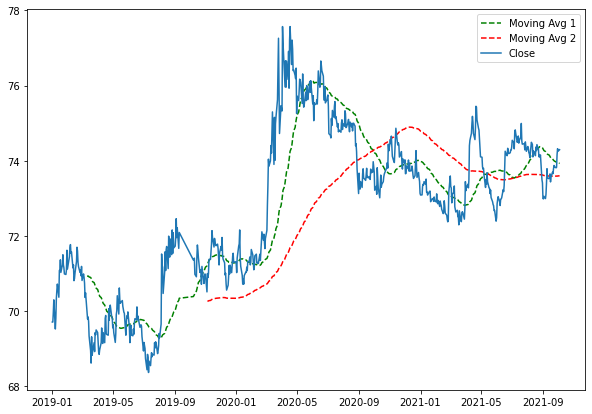

In [73]:
plot_avg(usd_inr)

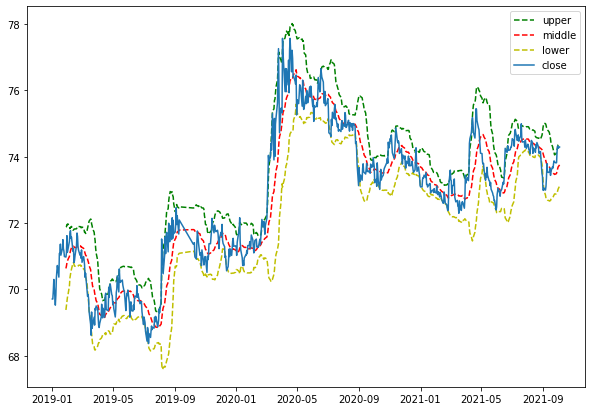

In [74]:
plot_bollinger(usd_inr)

499/499 [==============================] - 5s 6ms/step - loss: 0.0086
rms = 0.44715277815878607


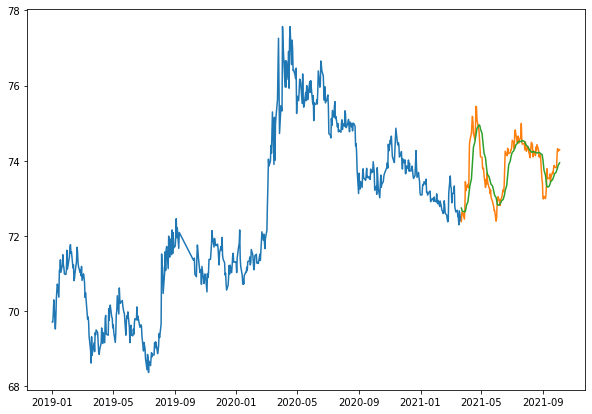

In [75]:
lstm_model(usd_inr,l = 60,n_units = 50)

### combined analysis

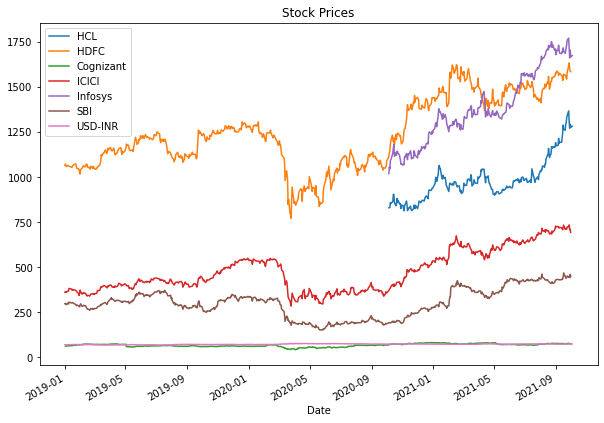

In [83]:
hcl['Open'].plot(label = 'HCL', figsize = (10,7))
hdfc['Open'].plot(label = "HDFC")
cognizant['Open'].plot(label = 'Cognizant')
icici['Open'].plot(label = 'ICICI')
infosys['Open'].plot(label = 'Infosys')
sbi['Open'].plot(label = 'SBI')
usd_inr['Open'].plot(label = 'USD-INR')
plt.legend()
plt.title('Stock Prices')
plt.savefig('imgs/cmbd.png')

In [84]:
data_frames = [hcl,hdfc,icici,infosys,sbi,usd_inr]

In [121]:
merged_df = pd.DataFrame(columns = ['hcl','hdfc','icici','infosys','sbi','usd_inr','date'],index=hcl.index)

In [122]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2020-10-05 to 2021-10-04
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hcl      0 non-null      object
 1   hdfc     0 non-null      object
 2   icici    0 non-null      object
 3   infosys  0 non-null      object
 4   sbi      0 non-null      object
 5   usd_inr  0 non-null      object
 6   date     0 non-null      object
dtypes: object(7)
memory usage: 25.5+ KB


In [99]:
hcl.index

DatetimeIndex(['2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
               '2020-10-09', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16',
               ...
               '2021-09-21', '2021-09-22', '2021-09-23', '2021-09-24',
               '2021-09-27', '2021-09-28', '2021-09-29', '2021-09-30',
               '2021-10-01', '2021-10-04'],
              dtype='datetime64[ns]', name='Date', length=248, freq=None)

In [127]:
data_frames = [hcl,hdfc,icici,infosys,sbi,usd_inr]
for date in hcl.index:
    data = []
    for i in data_frames:
        data.append(i['Close'][date])
    data.append(date)
    merged_df.loc[date] = data

KeyError: Timestamp('2021-10-04 00:00:00')

In [128]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2020-10-05 to 2021-10-04
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hcl      247 non-null    object
 1   hdfc     247 non-null    object
 2   icici    247 non-null    object
 3   infosys  247 non-null    object
 4   sbi      247 non-null    object
 5   usd_inr  247 non-null    object
 6   date     247 non-null    object
dtypes: object(7)
memory usage: 25.5+ KB


In [132]:
for i in ['hcl','hdfc','icici','infosys','sbi','usd_inr']:
    merged_df[i] = pd.to_numeric(merged_df[i])

In [133]:
# try to predict hdfc with all other data
corr = merged_df.corr()
corr.style.background_gradient(cmap='coolwarm',)

,hcl,hdfc,icici,infosys,sbi,usd_inr
hcl,1.000000,0.639972,0.764804,0.882077,0.688505,0.029473
hdfc,0.639972,1.000000,0.859700,0.657976,0.824707,-0.240733
icici,0.764804,0.859700,1.000000,0.893415,0.968308,-0.025627
infosys,0.882077,0.657976,0.893415,1.000000,0.857045,0.189537
sbi,0.688505,0.824707,0.968308,0.857045,1.000000,-0.048578
usd_inr,0.029473,-0.240733,-0.025627,0.189537,-0.048578,1.000000
